# Food Classification Model with EfficientNetB0

This notebook implements a food classification model using transfer learning with EfficientNetB0.
The implementation includes:
- Hardware setup and configuration
- Data preparation and augmentation
- Model building with transfer learning
- Training with feature extraction
- Fine-tuning
- Model evaluation and visualization

## 1. Hardware Check and Imports
First, let's check GPU availability and import required libraries

In [9]:
!nvidia-smi

Sat Apr 19 23:01:25 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.01             Driver Version: 572.16       CUDA Version: 12.8     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4090        On  | 00000000:01:00.0  On |                  Off |
|  0%   43C    P2              53W / 450W |   5085MiB / 24564MiB |      1%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [10]:
import os
import time
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_preprocess
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras import mixed_precision

## 2. Configuration and Setup
Define paths, hyperparameters, and configure hardware

In [11]:
# Configuration
TRAIN_DIR = r"../new_food_ds/new_dataset/train"
TEST_DIR = r"../new_food_ds/new_dataset/test"
CLASS_NAMES_PATH = r"../new_food_ds/new_dataset/class_names.txt"
MODEL_SAVE_PATH = "./implementation/refined_food_model_efficientnetb0_adamw.keras"
BEST_CHECKPOINT_PATH = "./implementation/best_food_model_checkpoint.keras"

# Hyperparameters
IMG_SIZE = 224
BATCH_SIZE = 64
INITIAL_EPOCHS = 50
FINE_TUNE_EPOCHS = 30
INITIAL_LR = 1e-4
FINE_TUNE_LR = 1e-5
WEIGHT_DECAY_INITIAL = 1e-5
WEIGHT_DECAY_FINETUNE = 1e-6
LABEL_SMOOTHING = 0.1
DROPOUT_RATE = 0.4

In [12]:
# Hardware Setup
print("TensorFlow version:", tf.__version__)

# Configure CPU parallelism
num_cores = os.cpu_count()
print(f"CPU cores available: {num_cores}")
if num_cores:
    tf.config.threading.set_inter_op_parallelism_threads(num_cores)
    tf.config.threading.set_intra_op_parallelism_threads(num_cores)
    print("CPU parallelism configured.")

# Check for GPU and configure
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    print(f"GPU devices available: {len(physical_devices)}")
    for device in physical_devices:
        print(f" - {device.name}")

    # Enable memory growth for GPUs
    try:
        for gpu in physical_devices:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("Memory growth enabled for GPUs.")
    except RuntimeError as e:
        print(f"Error setting memory growth: {e}")

    # Enable mixed precision training
    try:
        policy = mixed_precision.Policy('mixed_float16')
        mixed_precision.set_global_policy(policy)
        print(f"Mixed precision policy set to: {mixed_precision.global_policy().name}")
    except Exception as e:
        print(f"Warning: Could not set mixed precision: {e}")
        print("Continuing with default precision (float32).")
else:
    print("No GPU devices found. Running on CPU.")
    mixed_precision.set_global_policy('float32')
    print(f"Precision policy set to: {mixed_precision.global_policy().name}")

TensorFlow version: 2.19.0
CPU cores available: 12
CPU parallelism configured.
GPU devices available: 1
 - /physical_device:GPU:0
Memory growth enabled for GPUs.
Mixed precision policy set to: mixed_float16


## 3. Data Preparation
Load class names and set up data generators

In [13]:
# Load class names
with open(CLASS_NAMES_PATH, 'r', encoding='utf-8') as f:
    class_names = [line.strip() for line in f.readlines()]
num_classes = len(class_names)
print(f"Found {num_classes} classes.")

# Data generators
train_datagen = ImageDataGenerator(
    preprocessing_function=efficientnet_preprocess,
    rotation_range=20,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(
    preprocessing_function=efficientnet_preprocess
)

print("Creating generators...")
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

print("Class Indices (Train):", train_generator.class_indices)
print("Class Indices (Test):", test_generator.class_indices)

Found 149 classes.
Creating generators...


Found 87161 images belonging to 149 classes.
Found 22806 images belonging to 149 classes.
Class Indices (Train): {'Areeka(Yemen)': 0, 'Aseeda(Yemen)': 1, 'Balaleet(Qatar)': 2, 'EshAsaraya(Qatar)': 3, 'Fahsa(Yemen)': 4, 'GersOgaily(Kuwait)': 5, 'Harees(Qatar)': 6, 'Harissah(Yemen)': 7, 'Lahooh(Yemen)': 8, 'Luqaimat(Qatar)': 9, 'Malooga(Yemen)': 10, 'Mandi(Yemen)': 11, 'Maraq(Yemen)': 12, 'Margoog(Qatar)': 13, 'Markook(KSA)': 14, 'Martabak(Yemen)': 15, 'Masoub(Yemen)': 16, 'Mathrooba-Madrooba(Qatar-Oman)': 17, 'Megalgel(Yemen)': 18, 'Mehalabiya(Qatar)': 19, 'Mishkak(Oman)': 20, 'Mumawwash(Kuwait)': 21, 'MutabbaqSamaq(Kuwait)': 22, 'OmaniHalwa(Oman)': 23, 'Saleeg(KSA)': 24, 'Shafuut(Yemen)': 25, 'Shakshuka(yemen)': 26, 'Thareed(Qatar-KSA)': 27, 'UmmAli(Qatar)': 28, 'Zhoug(Yemen)': 29, 'apple_pie': 30, 'baby_back_ribs': 31, 'baklava': 32, 'beef_carpaccio': 33, 'beef_tartare': 34, 'beet_salad': 35, 'beignets': 36, 'bibimbap': 37, 'bread_pudding': 38, 'breakfast_burrito': 39, 'bruschetta': 4

## 4. Model Building
Define and build the model architecture

In [14]:
def build_model(num_classes, img_size=224, dropout_rate=0.4):
    inputs = Input(shape=(img_size, img_size, 3))
    
    base_model = EfficientNetB0(
        include_top=False,
        weights='imagenet',
        input_tensor=inputs,
        input_shape=(img_size, img_size, 3)
    )
    base_model.trainable = False
    
    x = base_model.output
    x = GlobalAveragePooling2D(name="avg_pool")(x)
    x = Dropout(dropout_rate, name="top_dropout")(x)
    x = Dense(1024, activation='relu', name="dense_1024")(x)
    outputs = Dense(num_classes, activation='softmax', dtype='float32', name="predictions")(x)
    
    return Model(inputs, outputs), base_model

# Build model
model, base_model = build_model(num_classes, IMG_SIZE, DROPOUT_RATE)

# Compile model
optimizer_initial = AdamW(learning_rate=INITIAL_LR, weight_decay=WEIGHT_DECAY_INITIAL)
loss_fn = tf.keras.losses.CategoricalCrossentropy(label_smoothing=LABEL_SMOOTHING)

model.compile(optimizer=optimizer_initial,
              loss=loss_fn,
              metrics=['accuracy'])

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast_2 (Cast)       │ (None, 224, 224,  │          0 │ input_layer_1[0]… │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_2         │ (None, 224, 224,  │          0 │ cast_2[0][0]      │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_1     │ (None, 224, 224,  │          7 │ rescaling_2[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_3         │ (None, 224, 224,  │          0 │ normalization_1[… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_3[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati

 Total params: 5,514,040 (21.03 MB)

 Trainable params: 1,464,469 (5.59 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

## 5. Training
Set up callbacks and train the model

In [15]:
# Callbacks
callbacks_list = [
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        verbose=1,
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        verbose=1,
        min_lr=1e-7
    ),
    ModelCheckpoint(
        filepath=BEST_CHECKPOINT_PATH,
        monitor='val_accuracy',
        save_best_only=True,
        save_weights_only=False,
        verbose=1
    )
]

# Initial training
print("Starting initial training...")
steps_per_epoch = max(1, train_generator.samples // BATCH_SIZE)
validation_steps = max(1, test_generator.samples // BATCH_SIZE)

history = model.fit(
    train_generator,
    epochs=INITIAL_EPOCHS,
    validation_data=test_generator,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=callbacks_list
)

Starting initial training...
Epoch 1/50
Epoch 1/50
 449/1361 ━━━━━━━━━━━━━━━━━━━━ 5:33 365ms/step - accuracy: 0.1311 - loss: 4.4882

/home/howweare/testing/.venv/lib/python3.11/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


 702/1361 ━━━━━━━━━━━━━━━━━━━━ 3:58 362ms/step - accuracy: 0.1790 - loss: 4.2504

2025-04-19 23:05:58.912181: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_10576', 8 bytes spill stores, 8 bytes spill loads

2025-04-19 23:05:58.985351: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_10576', 164 bytes spill stores, 164 bytes spill loads

2025-04-19 23:05:59.181539: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_10576_0', 352 bytes spill stores, 352 bytes spill loads

2025-04-19 23:05:59.206446: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_10576', 1436 bytes spill stores, 1420 bytes spill loads

2025-04-19 23:05:59.370145: 

1361/1361 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step - accuracy: 0.2555 - loss: 3.8475

2025-04-19 23:10:03.693576: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2339_0', 112 bytes spill stores, 120 bytes spill loads

2025-04-19 23:10:03.750490: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2339', 248 bytes spill stores, 248 bytes spill loads




Epoch 1: val_accuracy improved from -inf to 0.53919, saving model to ./implementation/best_food_model_checkpoint.keras
1361/1361 ━━━━━━━━━━━━━━━━━━━━ 547s 395ms/step - accuracy: 0.2556 - loss: 3.8471 - val_accuracy: 0.5392 - val_loss: 2.4368 - learning_rate: 1.0000e-04
Epoch 2/50
1361/1361 ━━━━━━━━━━━━━━━━━━━━ 547s 395ms/step - accuracy: 0.2556 - loss: 3.8471 - val_accuracy: 0.5392 - val_loss: 2.4368 - learning_rate: 1.0000e-04
Epoch 2/50
   1/1361 ━━━━━━━━━━━━━━━━━━━━ 16s 12ms/step - accuracy: 0.5000 - loss: 2.6026

/home/howweare/testing/.venv/lib/python3.11/site-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy did not improve from 0.53919
1361/1361 ━━━━━━━━━━━━━━━━━━━━ 29s 21ms/step - accuracy: 0.5000 - loss: 2.6026 - val_accuracy: 0.5392 - val_loss: 2.4361 - learning_rate: 1.0000e-04
Epoch 3/50
1361/1361 ━━━━━━━━━━━━━━━━━━━━ 29s 21ms/step - accuracy: 0.5000 - loss: 2.6026 - val_accuracy: 0.5392 - val_loss: 2.4361 - learning_rate: 1.0000e-04
Epoch 3/50
1361/1361 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step - accuracy: 0.5071 - loss: 2.5760
Epoch 3: val_accuracy improved from 0.53919 to 0.60060, saving model to ./implementation/best_food_model_checkpoint.keras

Epoch 3: val_accuracy improved from 0.53919 to 0.60060, saving model to ./implementation/best_food_model_checkpoint.keras
1361/1361 ━━━━━━━━━━━━━━━━━━━━ 492s 361ms/step - accuracy: 0.5071 - loss: 2.5759 - val_accuracy: 0.6006 - val_loss: 2.2370 - learning_rate: 1.0000e-04
Epoch 4/50
1361/1361 ━━━━━━━━━━━━━━━━━━━━ 492s 361ms/step - accuracy: 0.5071 - loss: 2.5759 - val_accuracy: 0.6006 - val_loss: 2.2370 - learning_rate: 1.

## 6. Fine-tuning
Unfreeze layers and fine-tune the model

In [16]:
# Fine-tuning setup
base_model.trainable = True
fine_tune_at = -20

if abs(fine_tune_at) > len(base_model.layers):
    print(f"Warning: fine_tune_at ({fine_tune_at}) is out of bounds. Unfreezing all layers.")
    fine_tune_at = 0

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Recompile with lower learning rate
optimizer_finetune = AdamW(learning_rate=FINE_TUNE_LR, weight_decay=WEIGHT_DECAY_FINETUNE)
model.compile(optimizer=optimizer_finetune,
              loss=loss_fn,
              metrics=['accuracy'])

model.summary()
print(f"Number of trainable variables: {len(model.trainable_variables)}")

# Fine-tuning training
initial_epoch_ft = history.epoch[-1] + 1 if history.epoch else 0

fine_tune_history = model.fit(
    train_generator,
    epochs=initial_epoch_ft + FINE_TUNE_EPOCHS,
    initial_epoch=initial_epoch_ft,
    validation_data=test_generator,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=callbacks_list
)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast_2 (Cast)       │ (None, 224, 224,  │          0 │ input_layer_1[0]… │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_2         │ (None, 224, 224,  │          0 │ cast_2[0][0]      │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_1     │ (None, 224, 224,  │          7 │ rescaling_2[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_3         │ (None, 224, 224,  │          0 │ normalization_1[… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_3[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati

 Total params: 5,514,040 (21.03 MB)

 Trainable params: 2,815,429 (10.74 MB)

 Non-trainable params: 2,698,611 (10.29 MB)

Number of trainable variables: 23
Epoch 51/80
Epoch 51/80
1361/1361 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - accuracy: 0.5090 - loss: 2.7369
Epoch 51: val_accuracy did not improve from 0.69672
1361/1361 ━━━━━━━━━━━━━━━━━━━━ 514s 368ms/step - accuracy: 0.5091 - loss: 2.7367 - val_accuracy: 0.6679 - val_loss: 2.0223 - learning_rate: 1.0000e-05
Epoch 52/80

Epoch 51: val_accuracy did not improve from 0.69672
1361/1361 ━━━━━━━━━━━━━━━━━━━━ 514s 368ms/step - accuracy: 0.5091 - loss: 2.7367 - val_accuracy: 0.6679 - val_loss: 2.0223 - learning_rate: 1.0000e-05
Epoch 52/80
   1/1361 ━━━━━━━━━━━━━━━━━━━━ 20s 15ms/step - accuracy: 0.6406 - loss: 2.2230
Epoch 52: val_accuracy did not improve from 0.69672
1361/1361 ━━━━━━━━━━━━━━━━━━━━ 28s 21ms/step - accuracy: 0.6406 - loss: 2.2230 - val_accuracy: 0.6677 - val_loss: 2.0222 - learning_rate: 1.0000e-05
Epoch 53/80

Epoch 52: val_accuracy did not improve from 0.69672
1361/1361 ━━━━━━━━━━━━━━━━━━━━ 28s 21ms/step - accuracy: 0.6406 - loss: 2.2230 - val_ac

## 7. Evaluation and Visualization
Evaluate the model and plot training history

In [17]:
# Final evaluation
final_loss, final_acc = model.evaluate(test_generator, steps=validation_steps)
print(f"\nFinal Test Loss: {final_loss:.4f}")
print(f"Final Test Accuracy: {final_acc:.4f}")

# Save model
print(f"\nSaving final model to: {MODEL_SAVE_PATH}")
model.save(MODEL_SAVE_PATH)
print("Model saved successfully.")

356/356 ━━━━━━━━━━━━━━━━━━━━ 28s 78ms/step - accuracy: 0.7542 - loss: 1.7514
356/356 ━━━━━━━━━━━━━━━━━━━━ 28s 78ms/step - accuracy: 0.7542 - loss: 1.7514

Final Test Loss: 1.8033
Final Test Accuracy: 0.7329

Saving final model to: ./implementation/refined_food_model_efficientnetb0_adamw.keras

Final Test Loss: 1.8033
Final Test Accuracy: 0.7329

Saving final model to: ./implementation/refined_food_model_efficientnetb0_adamw.keras
Model saved successfully.
Model saved successfully.


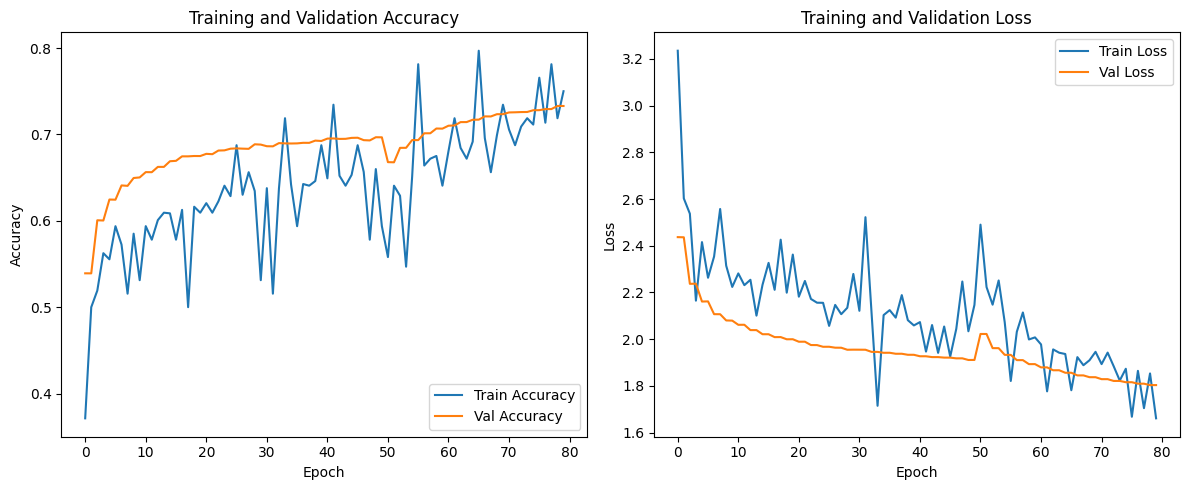

In [18]:
def plot_history(histories):
    acc = []
    val_acc = []
    loss = []
    val_loss = []
    
    for h in histories:
        if h and h.history:
            acc += h.history.get('accuracy', [])
            val_acc += h.history.get('val_accuracy', [])
            loss += h.history.get('loss', [])
            val_loss += h.history.get('val_loss', [])
        else:
            print("Warning: A history object was empty or None, skipping.")

    if not acc:
        print("No history data to plot.")
        return

    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Train Accuracy')
    plt.plot(epochs_range, val_acc, label='Val Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Train Loss')
    plt.plot(epochs_range, val_loss, label='Val Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.tight_layout()
    plt.show()

# Plot training history
plot_history([history, fine_tune_history])